In [4]:
import os
import time
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
# set path to folder containing clinic watch data
clinicpath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
# set path to folder containing home watch data
homepath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Patient Record Correlation'
# set path to destination folder
features = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Watch Features Data'
#---------------------------------------------------------------------------------------------------------

In [6]:
# generate task abbreviation dictionary
ClinicTasks = {
    'Stndg'    : 'Standing',
    'Wlkg'     : 'Walking',
    'WlkgCnt'  : 'Walking while counting',
    'FtnR'     : 'Finger to nose--right hand',
    'FtnL'     : 'Finger to nose--left hand',
    'RamR'     : 'Alternating right hand movements',
    'RamL'     : 'Alternating left hand movements',
    'SitStand' : 'Sit to stand',
    'Drwg'     : 'Drawing on a paper',
    'Typg'     : 'Typing on a computer keyboard',
    'NtsBts'   : 'Assembling nuts and bolts',
    'Drnkg'    : 'Taking a glass of water and drinking',
    'Sheets'   : 'Organizing sheets in a folder',
    'Fldg'     : 'Folding towels',
    'Sitng'    : 'Sitting'
}

In [7]:
DataFeatures = pd.read_csv(os.path.join(features, 'Clinic Data', 'ClinicDataFeaturesX.csv'))
DataFeatures.head()

,SubjID,Visit,TaskAbb,Clip,Tremor,Bradykinesia,Dyskinesia,Overall,RMSX,RMSY,...,Sen_X,Sen_Y,Sen_Z,RMS_mag,range_mag,mean_mag,var_mag,skew_mag,kurt_mag,Sen_mag
0,1003.0,0,Drnkg,0,1.0,1.0,0.0,1.0,0.003307,0.002409,...,1.280704,1.386294,1.396967,0.000703,0.065298,0.006188,0.009186,3.487845,14.708341,0.012476
1,1003.0,0,Drnkg,1,1.0,1.0,0.0,1.0,0.005253,0.008123,...,0.959580,0.575852,0.742688,0.005957,0.897089,0.034245,0.087334,6.468010,51.769176,0.011136
2,1003.0,0,Drnkg,2,1.0,1.0,0.0,1.0,0.005203,0.009098,...,1.217019,0.722551,0.846374,0.006222,0.897081,0.042083,0.088483,6.029726,46.903740,0.011594
3,1003.0,0,Drnkg,3,1.0,1.0,0.0,1.0,0.004530,0.006995,...,1.207064,0.759448,0.988522,0.002867,0.262082,0.024327,0.038040,2.970488,10.522799,0.014210
4,1003.0,0,Drnkg,4,1.0,1.0,0.0,1.0,0.006927,0.013675,...,1.319454,0.953987,1.503321,0.007170,0.752276,0.065797,0.091757,3.083533,14.513282,0.016023


In [8]:
features_list = list(DataFeatures.columns[8:])
# isolate metadata from datafeatures file
MetaData = DataFeatures[['SubjID', 'Visit', 'TaskAbb', 'Clip', 'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall']]
# isolate features from datafeatures file
Features = StandardScaler().fit_transform(DataFeatures[features_list].values)

# initialize principle component analysis with desired number of components (only two or three can be visualized)
pca = PCA(n_components = 3)
# fit the PCA to the features of the clinic data and organize into a dataframe with the metadata
princComp = pca.fit_transform(Features)
princComp = pd.DataFrame(princComp, columns = ['PC1', 'PC2', 'PC3'])
DataPCA = pd.concat([MetaData, princComp], axis = 1)

# display the amount of variance represented by each principle component
print(pca.explained_variance_ratio_)
DataPCA.head()

[0.29014175 0.13272264 0.0652632 ]


,SubjID,Visit,TaskAbb,Clip,Tremor,Bradykinesia,Dyskinesia,Overall,PC1,PC2,PC3
0,1003.0,0,Drnkg,0,1.0,1.0,0.0,1.0,-1.876328,0.759233,-0.688210
1,1003.0,0,Drnkg,1,1.0,1.0,0.0,1.0,0.213879,3.029144,-2.034311
2,1003.0,0,Drnkg,2,1.0,1.0,0.0,1.0,0.205672,2.509805,-1.690101
3,1003.0,0,Drnkg,3,1.0,1.0,0.0,1.0,-0.607318,0.473537,-1.565885
4,1003.0,0,Drnkg,4,1.0,1.0,0.0,1.0,0.243753,-0.335154,-0.411215


In [9]:
def plotPCA(sympt, tasks, scored, comp):
    '''visualize the organization of the segmented recording clips (from which features have been extracted)
    plot the location of these clips in space characterized by the principle components attributed to them
    
    sympt: symptom or label type to be considered in the PCA
    tasks: tasks to be considered
    scored: True or False based on whether scores should be binary or all scores should be considered
    comp: number of principle componenets to be extracted (2 for 2D and 3 for 3D)'''
    
    features_list = list(DataFeatures.columns[8:])
    MetaData = DataFeatures[['SubjID', 'Visit', 'TaskAbb', 'Clip', 'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall']]
    Features = StandardScaler().fit_transform(DataFeatures[features_list].values)

    # initialize the principle component analysis
    pca = PCA(n_components = comp)
    # fit the PCA to the features of all of the data
    princComp = pca.fit_transform(Features)
    if comp == 3:
        princComp = pd.DataFrame(princComp, columns = ['PC1', 'PC2', 'PC3'])
    if comp == 2:
        princComp = pd.DataFrame(princComp, columns = ['PC1', 'PC2'])
    
    # combine the metadata with the attributed principle component values
    DataPCA = pd.concat([MetaData, princComp], axis = 1)
    # now filer the metadata and PCA data based on tasks of interest
    indices = (x for x in range(len(DataPCA)) if DataPCA.TaskAbb.values[x] in tasks)
    DataPCA = DataPCA.loc[indices]
    
    # plot the location of each clip of acceleration data according to position in PCA space
    if comp == 3:
        fig = plt.figure(figsize = (16, 12))
        ax = Axes3D(fig)
    if comp == 2:
        plt.figure(figsize = (16, 12))
    if scored:
        Scores = list(DataPCA[sympt].unique())
    else:
        Scores = ['Symptomatic', 'Non-Symptomatic']
    # format list of the scores by which to group points on the scatter plot for visualization
    for score in Scores:
        if not type(score) == str:
            if np.isnan(score):
                continue
        if scored or sympt == 'TaskAbb':
            ScoreData = DataPCA[DataPCA[sympt] == score]
        elif score == 'Symptomatic':
            ScoreData = DataPCA[DataPCA[sympt] > 0]
        elif score == 'Non-Symptomatic':
            ScoreData = DataPCA[DataPCA[sympt] == 0]
        if comp == 3:
            ax.scatter(ScoreData.PC1.values, ScoreData.PC2.values, ScoreData.PC3.values)
        if comp == 2:
            plt.scatter(ScoreData.PC1.values, ScoreData.PC2.values)
    # different scores will be plotted in different colors to determine how data is segregated with the features used
    plt.legend(Scores)
    plt.xlabel('Principle Component 1')
    plt.ylabel('Principle Component 2')
    if comp == 3:
        ax.set_zlabel('Principle Component 3')
        
#     ax.set_zlim3d(-5, 10)
#     ax.set_ylim3d(-10, 5)
#     ax.set_xlim3d(-5, 10)
    
    return DataPCA

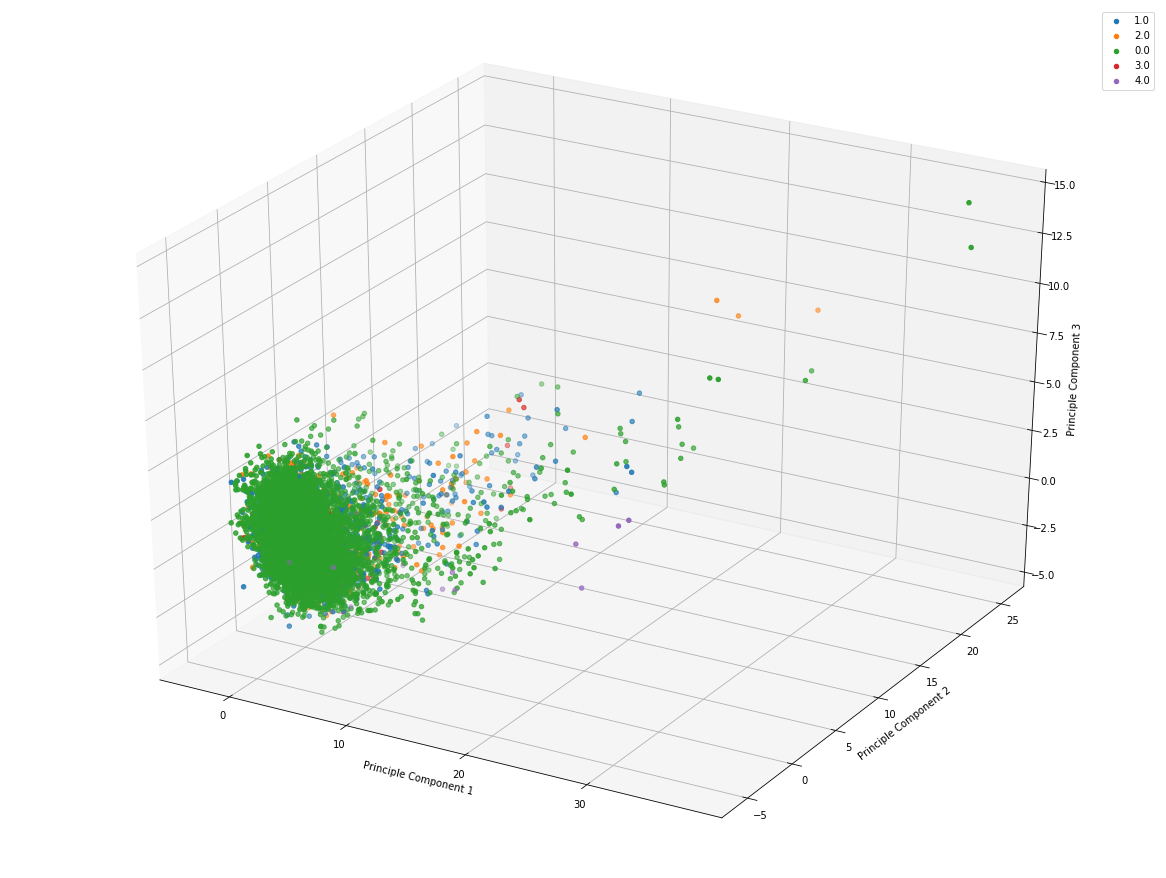

In [32]:
### TASKS
# tasks = ['Drnkg', 'Drwg', 'Fldg', 'FtnL', 'FtnR', 'NtsBts', 'RamL', 'RamR', 'Sheets', 'Sitng', 'SitStand', 'Stndg', 'Typg', 'Wlkg', 'WlkgCnt']
# tasks = ['RamL', 'RamR']
# tasks = ['FtnL', 'FtnR']
# tasks = ['Sitng', 'Stndg', 'Drwg']
# tasks = ['Wlkg', 'WlkgCnt']
tasks = ['Fldg', 'Sheets', 'Drnkg', 'NtsBts', 'Typg']

### LABEL_TYPE
# label_type = 'TaskAbb'
label_type = 'Tremor'
# label_type = 'Bradykinesia'
# label_type = 'Dyskinesia'
# label_type = 'Overall'

DataPCA = plotPCA(label_type, tasks, True, 3)

In [10]:
def TrainTestCluster(tasks, clusters):
    '''unsupervised clustering machine learning method KMeans
    
    tasks: tasks from which acceleration data/features will be considered
    clusters: number of clusters to break the data into'''
    
    # eliminate an unconcerning warning from being outputted
    pd.options.mode.chained_assignment = None
    
    # initialize the KMeans algorithm
    km = KMeans(n_clusters = clusters)
    
    # open the datafeatures file and filter based on the tasks of interest
    DataFeatures = pd.read_csv(os.path.join(features, 'Clinic Data', 'ClinicDataFeaturesX_FFTscoreFilt.csv'))
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
        
    features_list = list(DataFeatures.columns[8:])

    print('Tasks Considered:')
    for task in DataFeatures.TaskAbb.unique():
        print('    ' + ClinicTasks[task])
    
    DataClusters = pd.DataFrame()
    
    # complete clustering by each individual subject
    for subj in DataFeatures.SubjID.unique():
        
        # filter datafeatures to only include the subject of interest
        SubjFeatures = DataFeatures[DataFeatures.SubjID == subj]
        X = SubjFeatures[features_list].values
        
        # fit the clustering KMeans model on the features (unsupervised so no labels entered)
        km.fit(X)
        
        # get the labels attributed based on the clusters created by the model
        ClusterLab = km.labels_
        # append to the filtered dataframe the cluster given by the model
        SubjFeatures['Cluster'] = ClusterLab
        cols = ['SubjID', 'Visit', 'TaskAbb', 'Clip', 
                'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall', 'Cluster'] + features_list
        SubjFeatures = SubjFeatures[cols]
        # add the features file with the cluster information to a global dataframe (with all subjects)
        if DataClusters.empty:
            DataClusters = SubjFeatures
            continue
        DataClusters = pd.concat([DataClusters, SubjFeatures], ignore_index = True)
        
        MetaData = SubjFeatures[['SubjID', 'Visit', 'TaskAbb', 'Clip', 
                                 'Tremor', 'Bradykinesia', 'Dyskinesia', 'Overall', 'Cluster']]
        # normalize the features for PCA for visualization of clusters for each subject
        Features = StandardScaler().fit_transform(SubjFeatures[features_list].values)

        # complete 2D PCA
        pca = PCA(n_components = 2)
        princComp = pca.fit_transform(Features)
        princComp = pd.DataFrame(princComp, columns = ['PC1', 'PC2'], index = MetaData.index)

        # combine the PCA of each analyzed clip with the relevant metadata
        DataPCA = pd.concat([MetaData, princComp], axis = 1)

        plt.figure(figsize = (8, 6))
        
        Clusters = list(DataPCA.Cluster.unique())
        
        # plot the clusteres generated by the KMeans algorithm based on their PCA for visualization
        for cluster in Clusters:
            ClusterData = DataPCA[DataPCA.Cluster == cluster]
            plt.scatter(ClusterData.PC1.values, ClusterData.PC2.values)
        plt.legend(Clusters)
        plt.xlabel('Principle Component 1')
        plt.ylabel('Principle Component 2')
        plt.show()
        
    return DataClusters, km, pca

Tasks Considered:
    Sitting
    Standing


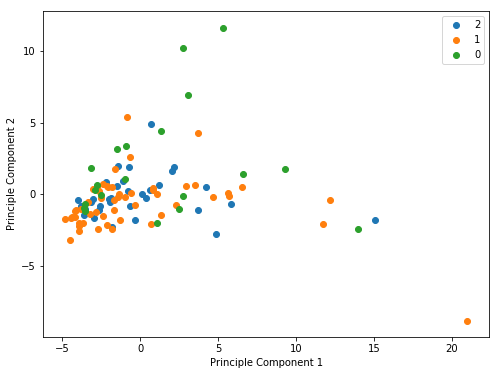

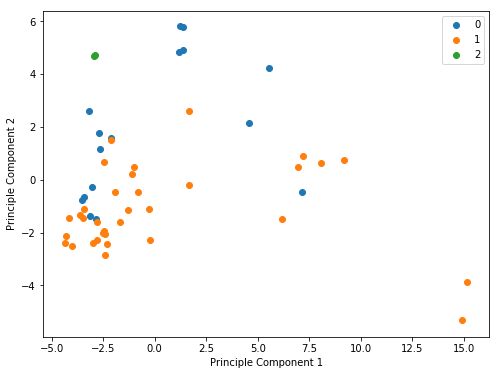

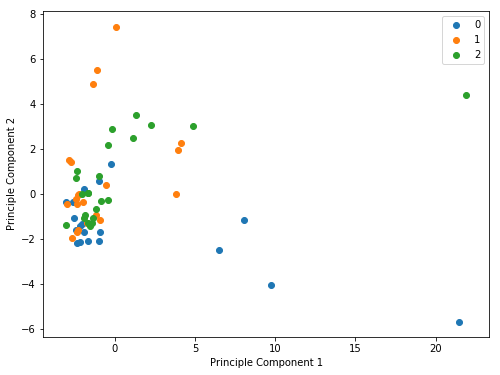

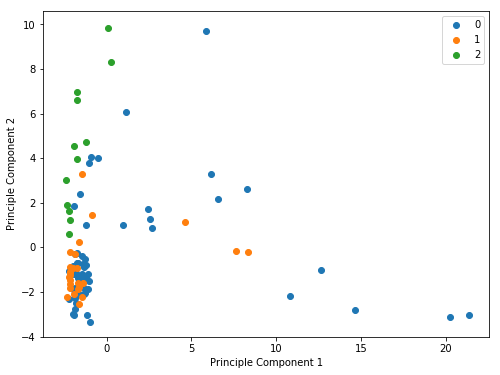

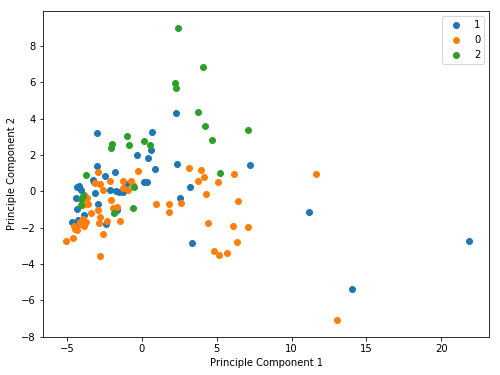

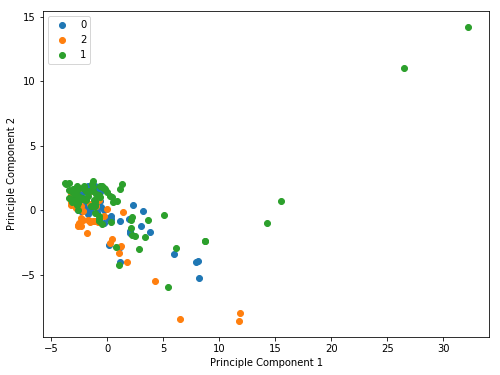

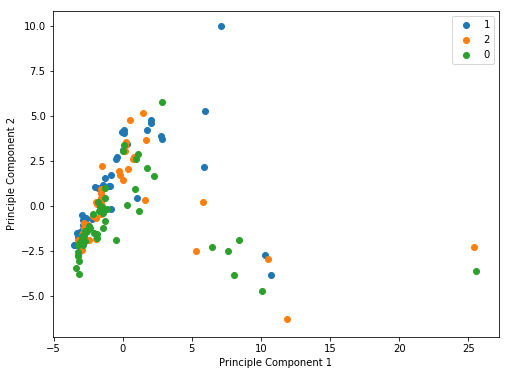

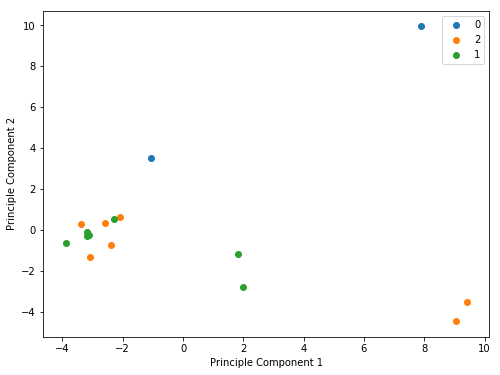

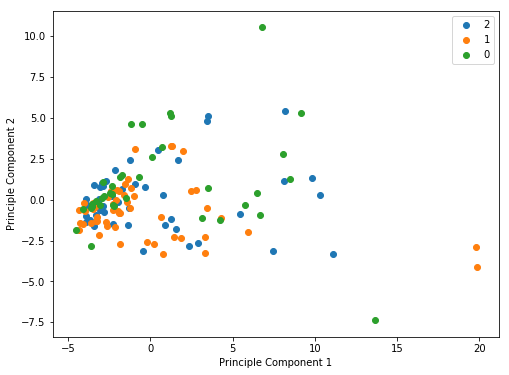

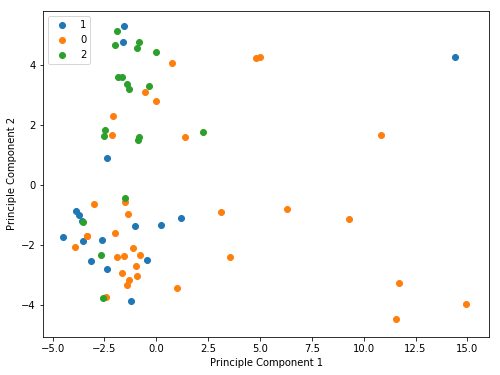

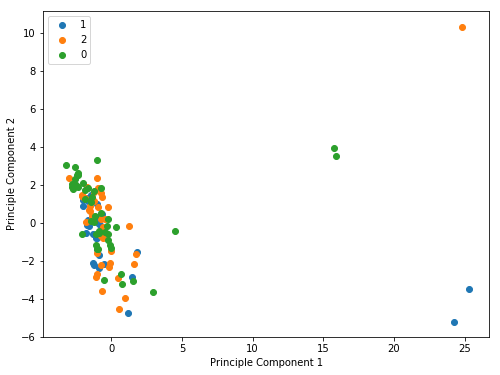

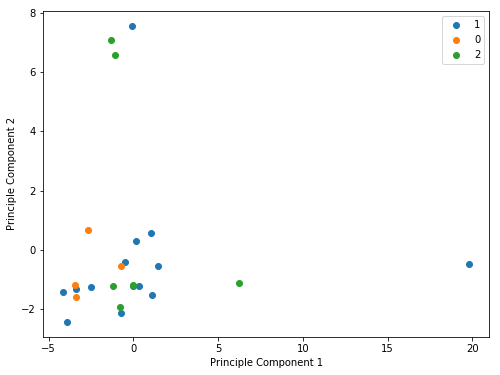

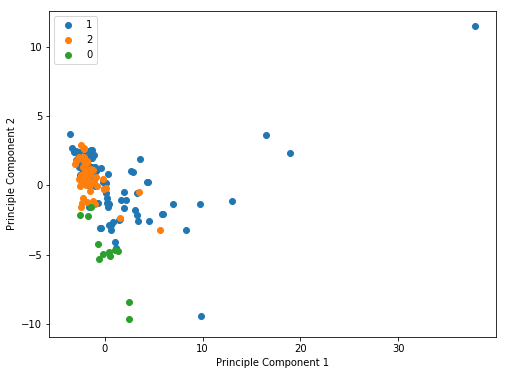

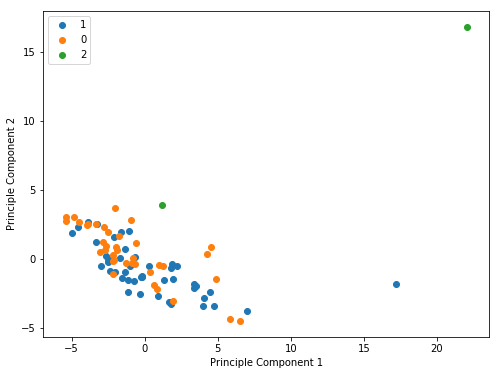

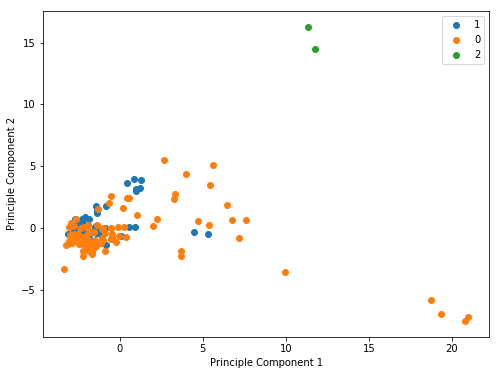

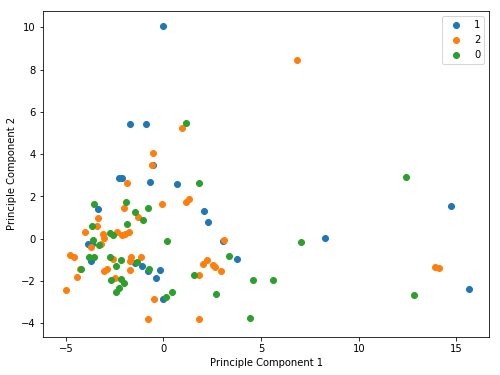

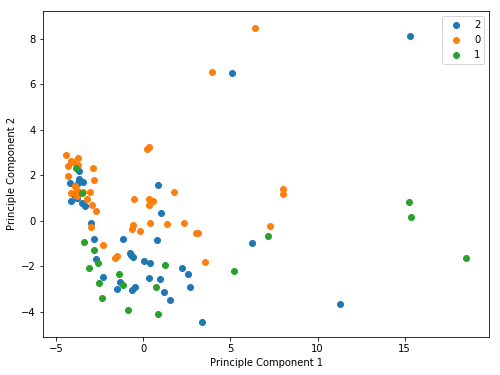

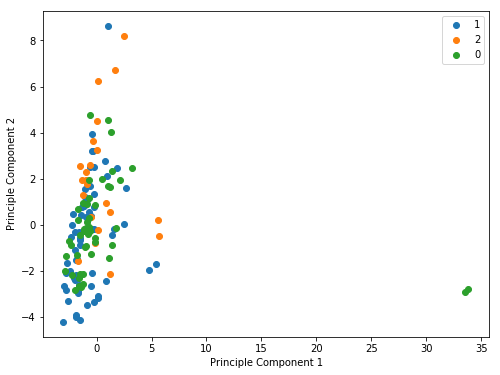

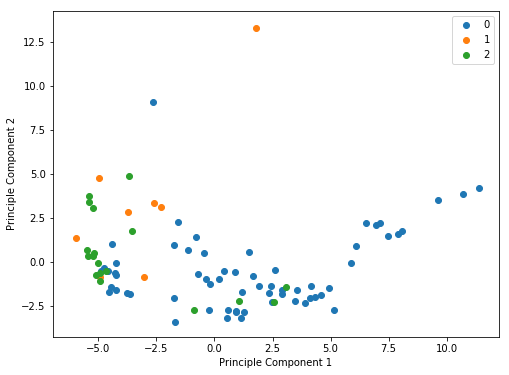

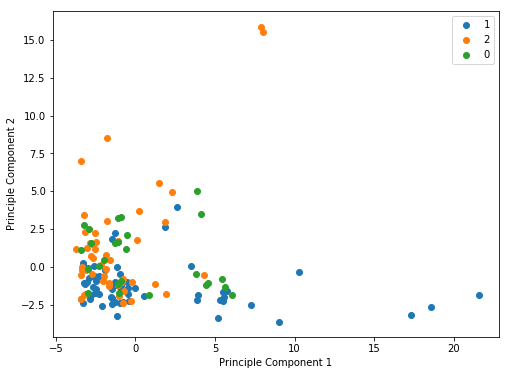

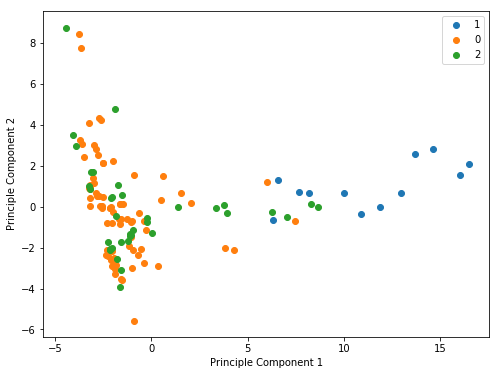

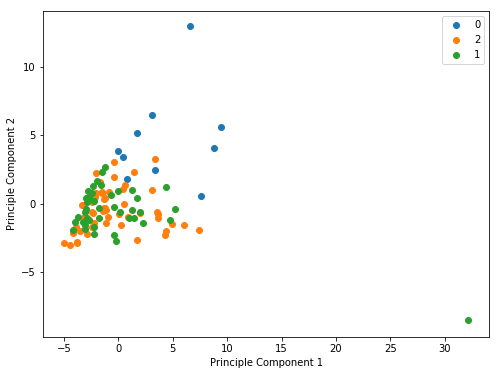

In [12]:
### TASKS
# tasks = ['Drnkg', 'Drwg', 'Fldg', 'FtnL', 'FtnR', 'NtsBts', 'RamL', 'RamR', 'Sheets', 'Sitng', 'SitStand', 'Stndg', 'Typg', 'Wlkg', 'WlkgCnt']
# tasks = ['RamL', 'RamR']
# tasks = ['FtnL', 'FtnR']
tasks = ['Sitng', 'Stndg']
# tasks = ['Wlkg', 'WlkgCnt']
# tasks = ['Fldg', 'Sheets', 'Drnkg', 'NtsBts', 'Typg', 'Drwg']

DataClusters, km, pca = TrainTestCluster(tasks, 3)

In [27]:
DataClusters.head()

,SubjID,Visit,TaskAbb,Clip,Tremor,Bradykinesia,Dyskinesia,Overall,Cluster,RMSX,...,Sen_X,Sen_Y,Sen_Z,RMS_mag,range_mag,mean_mag,var_mag,skew_mag,kurt_mag,Sen_mag
0,1003.0,0,Drwg,0,1.0,0.0,0.0,1.0,5,0.000775,...,1.799307,1.841770,2.007121,0.000030,0.002051,0.000316,0.000290,1.869467,5.981329,0.027008
1,1003.0,0,Drwg,1,1.0,0.0,0.0,1.0,1,0.000574,...,1.632427,1.743253,2.242265,0.000023,0.001307,0.000267,0.000244,1.544128,2.446828,0.018654
2,1003.0,0,Drwg,2,1.0,0.0,0.0,1.0,5,0.000426,...,1.822360,1.922256,2.100948,0.000026,0.002432,0.000294,0.000293,2.890688,13.503555,0.018269
3,1003.0,0,Drwg,3,1.0,0.0,0.0,1.0,4,0.000407,...,1.880639,1.997763,2.133789,0.000026,0.002425,0.000294,0.000283,2.977380,15.189153,0.020318
4,1003.0,0,Drwg,4,1.0,0.0,0.0,1.0,4,0.000393,...,2.045540,1.708935,2.093872,0.000022,0.001229,0.000267,0.000216,1.405528,2.365242,0.024141


In [13]:
# print information for comparing the data present in each cluster
for cluster in DataClusters.Cluster.unique():
    ClusterData = DataClusters[DataClusters.Cluster == cluster]
    print('------------------------------')
    print('Cluster ' + str(cluster))
    print(len(ClusterData))
    print('Mean Trem: ' + str(ClusterData.Tremor.mean()))
    print('Mean Brad: ' + str(ClusterData.Bradykinesia.mean()))
    print('Mean Dys: ' + str(ClusterData.Dyskinesia.mean()))
    print('------------------------------')

------------------------------
Cluster 0
877
Mean Trem: 0.4925883694412771
Mean Brad: nan
Mean Dys: 0.06157354618015964
------------------------------
------------------------------
Cluster 1
865
Mean Trem: 0.3606936416184971
Mean Brad: nan
Mean Dys: 0.048554913294797684
------------------------------
------------------------------
Cluster 2
623
Mean Trem: 0.3723916532905297
Mean Brad: nan
Mean Dys: 0.07223113964686999
------------------------------
